# Interpolation speed test

## User Specifications

In [1]:
### User can change these variables (unless they begin with an underscore) ###

drift_model = 'turnbull'  # must be 'turnbull' or 'wagner'
ocean_model = 'ecmwf'  # must be 'ecmwf'
atm_model = 'ecmwf'  # must be 'ecmwf'


iip_season = 2015  # must be 2015 (more to come later)

# Uncomment only one of the following
_method = 'index'; iip_indices = range(3283, 3285)  # iip_indices must be int or range
#_method = 'ID'; iip_ID = 20668  # iip_ID must be int

## Imports

In [2]:
from datetime import timedelta
import numpy as np
import numba

In [3]:
import netCDF4 as nc

In [4]:
if drift_model == 'turnbull':
    from icedef.turnbull import drift
elif drift_model == 'wagner':
    from iceberg.wagner import drift
else:
    print('drift model specified is invalid')
    
from icedef import iceberg, metocean, plot

## Iceberg Data

In [5]:
if _method == 'index':
    identifier = iip_indices
elif _method == 'ID':
    identifier = iip_ID
else:
    print("Invalid method specified. Please change _method to either 'index' or 'ID'")

In [6]:
iip_berg_df, iip_berg = iceberg.get_iip_iceberg(2015, _method, identifier)

/home/evankielley/IceDEF/icedef/iceberg.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  iip_df['TIMESTAMP'] += pd.to_timedelta(pd.to_datetime(iip_df['SIGHTING_TIME'], format='%H%M').dt.hour, unit='h')
/home/evankielley/IceDEF/icedef/iceberg.py:219: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  iip_df['TIMESTAMP'] += pd.to_timedelta(pd.to_datetime(iip_df['SIGHTING_TIME'], format='%H%M').dt.minute, unit='m')


In [7]:
iip_berg_df

index  ICEBERG_YEAR  ICEBERG_NUMBER SIGHTING_DATE  SIGHTING_TIME  \
0   3283          2015           20668     6/16/2015           1440   
1   3284          2015           20668     6/17/2015           1043   

   SIGHTING_LATITUDE  SIGHTING_LONGITUDE SIGHTING_METHOD SIZE SHAPE SOURCE  \
0              48.20              -50.18             R/V   LG   TAB   GTJZ   
1              48.16              -50.16             R/V   LG   GEN   GMRS   

            TIMESTAMP  
0 2015-06-16 14:40:00  
1 2015-06-17 10:43:00

In [8]:
mod_berg = iceberg.clone_iceberg_state(iip_berg)

## Metocean Data

In [9]:
%%time
ocean_data = metocean.ECMWF_Ocean(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

ocean_data.filenames

CPU times: user 2.27 s, sys: 1.63 s, total: 3.9 s
Wall time: 27.1 s


In [10]:
%%time
atm_data = metocean.ECMWF_Atm(min(iip_berg.history['X']), max(iip_berg.history['X']),
                         min(iip_berg.history['Y']), max(iip_berg.history['Y']),
                         iip_berg.history['T'][0], iip_berg.history['T'][-1])

atm_data.filenames

CPU times: user 81 ms, sys: 48.9 ms, total: 130 ms
Wall time: 1.94 s


## Timesteps

In [11]:
t0 = iip_berg.history['T'][0]
tf = iip_berg.history['T'][-1]
t_delta = tf - t0
t_delta_hours = t_delta.days*24 + t_delta.seconds/3600
t_step_hours = 0.1
t_step = timedelta(hours = t_step_hours)
dt = t_step_hours*3600  # timestep in seconds
t_all = []

for i in np.arange(0, t_delta_hours + t_step_hours, t_step_hours):
    new_date = t0 + timedelta(hours=i)
    t_all.append(new_date)

In [12]:
T = mod_berg.T
T_ocean = nc.date2num(T, ocean_data.t_units, ocean_data.t_calendar)
T_atm = nc.date2num(T, atm_data.t_units, atm_data.t_calendar)

t0 = T_ocean
y0 = mod_berg.Y
x0 = mod_berg.X
t0, x0, y0

(573782.6666666666, -50.18, 48.200000000000003)

In [20]:
t0_ocean = np.random.uniform(nc.date2num(iip_berg.history['T'][0], ocean_data.t_units, ocean_data.t_calendar), 
                  nc.date2num(iip_berg.history['T'][-1], ocean_data.t_units, ocean_data.t_calendar))
t0_atm = np.random.uniform(nc.date2num(iip_berg.history['T'][0], atm_data.t_units, atm_data.t_calendar), 
                  nc.date2num(iip_berg.history['T'][-1], atm_data.t_units, atm_data.t_calendar))
y0 = np.random.uniform(iip_berg.history['Y'][0], iip_berg.history['Y'][-1])
x0 = np.random.uniform(iip_berg.history['X'][0], iip_berg.history['X'][-1])
t0_ocean, t0_atm, y0, x0

(573791.5282041968, 1012071.884239308, 48.18501426646779, -50.16992263174019)

In [24]:
%timeit ocean_data.iUW([t0_ocean, y0, x0])[0], ocean_data.iVW([t0_ocean, y0, x0])[0]
ocean_data.iUW([t0_ocean, y0, x0])[0], ocean_data.iVW([t0_ocean, y0, x0])[0]

975 µs ± 44.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


(0.2110889608049529, -0.0044256952375596285)

In [25]:
%timeit ocean_data.get_interpolated_uv_velocities(t0_ocean, y0, x0)
ocean_data.get_interpolated_uv_velocities(t0_ocean, y0, x0)

103 µs ± 2.02 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


(0.19325944315585628, 0.0090118972389918884)

In [27]:
%timeit atm_data.iUA([t0_atm, y0, x0])[0], atm_data.iVA([t0_atm, y0, x0])[0]
atm_data.iUA([t0_atm, y0, x0])[0], atm_data.iVA([t0_atm, y0, x0])[0]

903 µs ± 26.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


(4.0234079166998136, 6.0435080169106836)

In [29]:
%timeit atm_data.get_interpolated_uv_velocities(t0_atm, y0, x0)
atm_data.get_interpolated_uv_velocities(t0_atm, y0, x0)

93.1 µs ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


(3.7555056538858844, 5.6056872062696614)

## James' Code

The primary function is `drift` which computes the total acceleration on an iceberg

In [12]:
drift(mod_berg, ocean_data, atm_data)

(1.4112229435207623e-05, 6.9538441544419683e-07)

In [13]:
%timeit drift(mod_berg, ocean_data, atm_data)

1.96 ms ± 96.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


This is about a 2 ms timestep, most of which is taken up by four interpolation function calls.

In [14]:
T = mod_berg.T
T_ocean = nc.date2num(T, ocean_data.t_units, ocean_data.t_calendar)
T_atm = nc.date2num(T, atm_data.t_units, atm_data.t_calendar)

In [15]:
%timeit ocean_data.iUW([T_ocean, mod_berg.Y, mod_berg.X])

464 µs ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
%timeit ocean_data.iVW([T_ocean, mod_berg.Y, mod_berg.X])

460 µs ± 25.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
%timeit atm_data.iUA([T_atm, mod_berg.Y, mod_berg.X])

463 µs ± 38.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
%timeit atm_data.iVA([T_atm, mod_berg.Y, mod_berg.X])

445 µs ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


So, to do a look up takes ~450 µs for the ocean data, and ~430 µs for the atmospheric data.

Interpolating to these coordinates

In [19]:
t0 = T_ocean
y0 = mod_berg.Y
x0 = mod_berg.X
t0, x0, y0

(573782.6666666666, -50.18, 48.200000000000003)

The array we are interpolating is

In [20]:
ocean_data.UW.shape

(48, 301, 301)

In [21]:
ocean_data.times

array([ 573768.5,  573769.5,  573770.5,  573771.5,  573772.5,  573773.5,
        573774.5,  573775.5,  573776.5,  573777.5,  573778.5,  573779.5,
        573780.5,  573781.5,  573782.5,  573783.5,  573784.5,  573785.5,
        573786.5,  573787.5,  573788.5,  573789.5,  573790.5,  573791.5,
        573792.5,  573793.5,  573794.5,  573795.5,  573796.5,  573797.5,
        573798.5,  573799.5,  573800.5,  573801.5,  573802.5,  573803.5,
        573804.5,  573805.5,  573806.5,  573807.5,  573808.5,  573809.5,
        573810.5,  573811.5,  573812.5,  573813.5,  573814.5,  573815.5], dtype=float32)

Ocean data is hourly

In [22]:
np.diff(ocean_data.times)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

The spatial grid

In [23]:
ocean_data.lats[:20]

array([ 40.        ,  40.08333206,  40.16666794,  40.25      ,
        40.33333206,  40.41666794,  40.5       ,  40.58333206,
        40.66666794,  40.75      ,  40.83333206,  40.91666794,
        41.        ,  41.08333206,  41.16666794,  41.25      ,
        41.33333206,  41.41666794,  41.5       ,  41.58333206], dtype=float32)

is very close to uniformly gridded in space

In [24]:
set(np.diff(ocean_data.lats))

{0.083328247, 0.083332062, 0.083335876}

In [25]:
ocean_data.lons[:20]

array([-65.        , -64.91666412, -64.83333588, -64.75      ,
       -64.66666412, -64.58333588, -64.5       , -64.41666412,
       -64.33333588, -64.25      , -64.16666412, -64.08333588,
       -64.        , -63.91666794, -63.83333206, -63.75      ,
       -63.66666794, -63.58333206, -63.5       , -63.41666794], dtype=float32)

In [26]:
set(np.diff(ocean_data.lons))

{0.083328247, 0.083332062, 0.083335876}

That means finding the _bounding box_ in T, Y, X should be simple.

In [60]:
xmin = ocean_data.lons[0]
dx = np.diff(ocean_data.lons).mean()
ymin = ocean_data.lats[0]
dy = np.diff(ocean_data.lats).mean()
tmin = ocean_data.times[0]
dt = np.diff(ocean_data.times).mean()

In [61]:
xmin, dx, ymin, dy, tmin, dt

(-65.0, 0.083333336, 40.0, 0.083333336, 573768.5, 1.0)

In [62]:
x0, y0, t0

(-50.18, 48.2, 573782.6666666666)

In [96]:
import numba

In [100]:
@numba.jit
def get_value(data, x0, y0, t0):

    i = (x0 - xmin)/dx
    j = (y0 - ymin)/dy
    n = (t0 - tmin)/dt

    (i0, di), (j0, dj), (n0, dn) = [(int(np.floor(x)), x - np.floor(x)) for x in [i, j, n]]

    A = data[n0:n0+2, i0:i0+2, j0:j0+2]

    B = dn* A[0, :, :] + (1-dn)*A[1, :, :]
    C = di * B[0, :] + (1-di)*B[1, :]
    D = dj * C[0] + (1-dj)*C[1]
    return D

In [102]:
%timeit get_value(ocean_data.UW, x0, y0, t0)

1.1 µs ± 4.06 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


## Drifting

In [17]:
%%prun -T "profiled_drift.txt"
earth_radius = 6378*1e3  # radius of Earth  (m)


# Buffer number for bounding spatial box
drift_xmin = max(min(ocean_data.lons), min(atm_data.lons))
drift_xmax = min(max(ocean_data.lons), max(atm_data.lons))
drift_ymin = max(min(ocean_data.lats), min(atm_data.lats))
drift_ymax = min(max(ocean_data.lats), max(atm_data.lats))


for t in t_all:

    mod_berg.T = t

    if drift_model == 'turnbull':
    
        ax, ay = drift(mod_berg, ocean_data, atm_data) 

        mod_berg.Vx += dt*ax  
        mod_berg.Vy += dt*ay

    elif drift_model == 'wagner':
    
        mod_berg.Vx, mod_berg.Vy = drift(mod_berg, ocean_data, atm_data) 

    
    # Iceberg position (note the conversion from meters back to degrees)
    y_ = mod_berg.Y
    mod_berg.Y += dt*mod_berg.Vy*(180/(np.pi*earth_radius))  # y-component of iceberg position (degrees latitude)
    mod_berg.X += dt*mod_berg.Vx/(np.cos((((y_ + mod_berg.Y)/2)*np.pi)/180))*(180/(np.pi*earth_radius))  # x-component of iceberg position (degrees longitude)

    if mod_berg.X > drift_xmax:
        print('Iceberg out-of-bounds')
        break

    elif mod_berg.X < drift_xmin: 
        print('Iceberg out-of-bounds')
        break

    elif mod_berg.Y > drift_ymax:
        print('Iceberg out-of-bounds')
        break

    elif mod_berg.Y < drift_ymin:
        print('Iceberg out-of-bounds')
        break


    else:
        mod_berg.history['T'].append(mod_berg.T)
        mod_berg.history['X'].append(mod_berg.X)
        mod_berg.history['Y'].append(mod_berg.Y)
        mod_berg.history['Vx'].append(mod_berg.Vx)
        mod_berg.history['Vy'].append(mod_berg.Vy)

print("Final time: {}".format(t)) 

Final time: 2015-06-17 10:46:00
 
*** Profile printout saved to text file '"profiled_drift.txt"'. 


## Plotting

/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/evankielley/.conda/envs/icedef/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1711: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


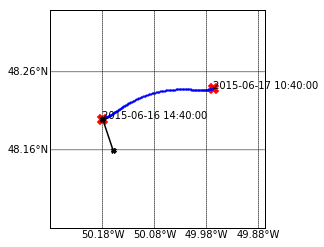

In [13]:
plot.plot_drift_track_test_case(iip_berg, mod_berg)